# Business understanding

Generator planet 
- format wejściowy plików:  1920px/1080px
- format wyjściowy plików:  64px/64px

In [1]:
# import niezbednych bibliotek
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [2]:
# wersja tensorflow
print('tensorflow ver: ', tf.__version__)
print('keras ver     : ', tf.keras.__version__)

tensorflow ver:  2.10.1
keras ver     :  2.10.0


# Data understanding and data preparation

Dataset zrobiony z modeli udostępnionych przez NASA na stronie: nasa.gov
- 12 planet/gwiazd
- 100 zdjęć na planetę/gwiazde

In [4]:
dir_directory_path = './DATA/v1'

images_data = []
images_labels = []
    
subfolders = [ f.path for f in os.scandir(dir_directory_path) if f.is_dir() ]

for dir_path in subfolders:
    print('Loading data from folder', dir_path.replace("\\", "/"))

    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                dir_path, 
                label_mode=None, 
                image_size=(64, 114), 
                batch_size=32,
                #color_mode='grayscale'
            )
    
    for i in dataset:
        for ii in i:            
            new_img = ii[0:64, 25:89]
            images_data.append(new_img)
            images_labels.append(dir_path.replace(dir_directory_path, '').replace('\\',''))
                        
images_data = np.asarray(images_data)
images_labels = np.asarray(images_labels)

new_images_data = []
new_images_labels = []

for idx in range(0, images_data.shape[0]):
    img = Image.fromarray(np.uint8(images_data[idx]))
    class_name = images_labels[idx]
    
    new_images_data.append(np.asarray(img))
    new_images_labels.append(class_name)
    
    for i in range(180, 360, 180):
        rotated_img = img.rotate(i)
        new_images_data.append(np.asarray(rotated_img))
        new_images_labels.append(class_name)
                        
images_data = np.asarray(new_images_data)
images_labels = np.asarray(new_images_labels)        

label_encoder = LabelEncoder()
images_labels_num = label_encoder.fit_transform(images_labels)

print()
print('Shapes:')
print('images_labels      :', images_labels.shape)
print('-----------------------------')
print('images_data        :', images_data.shape)
print('images_labels_num  :', images_labels_num.shape)

Loading data from folder ./DATA/v1/ceres
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth_moon
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/eris
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/hamuea
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/jupiter
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/makemake
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mars
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mercury
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/pluto
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/sun
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/venus
Found 100 files belonging to 1 classes.

Shapes:
images_lab

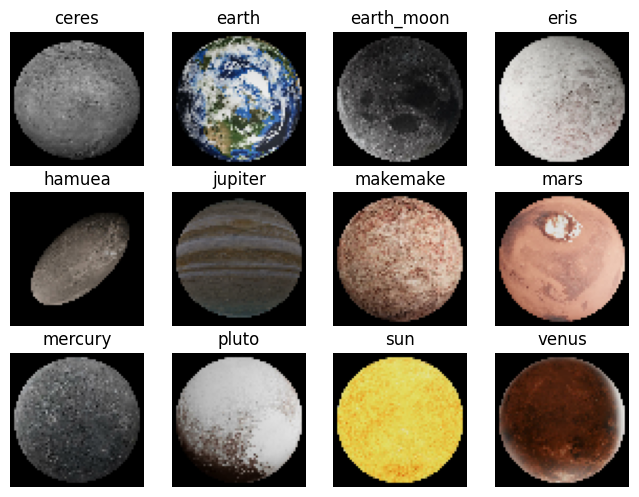

In [5]:
# pokazanie randomowych pozycji zdjęć
np.random.seed(100)

idx = 0
fig = plt.figure(figsize=(8, 8))
for i in np.unique(images_labels_num):    
    idx += 1
    class_position = np.where(images_labels_num  == i)[0]
    class_position = np.random.choice(class_position)
    plt.subplot(4, 4, idx)
    plt.imshow(images_data[class_position] / 255.)
    plt.title(images_labels[class_position])    
    plt.axis('off')
plt.show()
plt.close(fig)    

In [6]:
# Normalizacja zdjęć w przedziale wartości [-1, 1]
train_images = images_data
train_images = (train_images - 127.5) / 127.5  

train_images.shape

(2400, 64, 64, 3)

# Modeling

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [10]:
def build_generator(image_size):
    
    size = int(image_size / 4)
    
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(size * size * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((size, size, 256)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())    
    model.add(layers.LeakyReLU())

    # last layer 
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
        
    return model     


# build the generator model
generator = build_generator(64) 
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       25

c:\APLIKACJE\PyDataScience\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [11]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (3, 3), padding="same", strides=(2, 2), input_shape=input_shape))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(32, (3, 3), padding="same", strides=(2, 2)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # flatten and apply dropout
    model.add(layers.Flatten())
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model


# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [12]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}  

In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(3, 3))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('./results_064_v1/epoch_{:03d}.jpg'.format(epoch + 1)) 
        if epoch == 0 or epoch % 10 == 0:
            plt.show()
        plt.close(fig)
                
        for i in range(self.num_img):
            fig = plt.figure(figsize=(1, 1))
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
            plt.savefig('./results_064_v1/images/epoch_{:03d}_img_{:03d}.jpg'.format(epoch + 1, i + 1)) 
            plt.close(fig)
        if epoch == 0 or epoch % 5 == 0:
            self.model.generator.save('./results_064_v1/generator_{:03d}.h5'.format(epoch + 1))

    def on_train_end(self, logs=None):
        self.model.generator.save('./results_064_v1/generator_last.h5')

In [17]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

D_LR = 0.001 # UPDATED: discriminator learning rate
G_LR = 0.003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Evaluation

Epoch 1/500
75/75 [==============================] - ETA: 0s - d_loss: -4.5541 - g_loss: 6.2479e-08

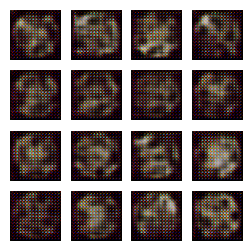

75/75 [==============================] - 15s 189ms/step - d_loss: -4.5541 - g_loss: 6.2479e-08
Epoch 2/500
75/75 [==============================] - 14s 184ms/step - d_loss: -72.5120 - g_loss: 0.0000e+00
Epoch 3/500
75/75 [==============================] - 14s 187ms/step - d_loss: 6104.6387 - g_loss: 64.2991
Epoch 4/500
75/75 [==============================] - 14s 182ms/step - d_loss: 6274.7461 - g_loss: 27.4296
Epoch 5/500
75/75 [==============================] - 14s 191ms/step - d_loss: 95.5951 - g_loss: 11.4270
Epoch 6/500
75/75 [==============================] - 15s 199ms/step - d_loss: 434.7714 - g_loss: 7.2467
Epoch 7/500
75/75 [==============================] - 15s 197ms/step - d_loss: 395.1669 - g_loss: 27.2052
Epoch 8/500
75/75 [==============================] - 15s 196ms/step - d_loss: 284.6167 - g_loss: 15.8007
Epoch 9/500
75/75 [==============================] - 15s 198ms/step - d_loss: 222.2427 - g_loss: 15.3874
Epoch 10/500
75/75 [==============================] - 15s 199m

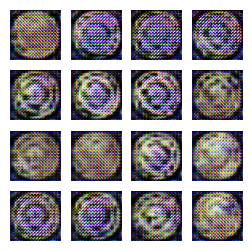

75/75 [==============================] - 15s 198ms/step - d_loss: 111.0483 - g_loss: 12.3111
Epoch 12/500
75/75 [==============================] - 15s 201ms/step - d_loss: 107.8937 - g_loss: 46.7639
Epoch 13/500
75/75 [==============================] - 15s 198ms/step - d_loss: 103.2668 - g_loss: 27.8025
Epoch 14/500
75/75 [==============================] - 15s 199ms/step - d_loss: 120.6497 - g_loss: 49.1308
Epoch 15/500
75/75 [==============================] - 15s 201ms/step - d_loss: 116.2934 - g_loss: 49.8167
Epoch 16/500
75/75 [==============================] - 15s 200ms/step - d_loss: 119.5718 - g_loss: 48.9627
Epoch 17/500
75/75 [==============================] - 15s 206ms/step - d_loss: 105.3804 - g_loss: 45.9049
Epoch 18/500
75/75 [==============================] - 15s 201ms/step - d_loss: 104.0058 - g_loss: 49.7646
Epoch 19/500
75/75 [==============================] - 15s 202ms/step - d_loss: 99.1222 - g_loss: 52.9200
Epoch 20/500
75/75 [==============================] - 15s 20

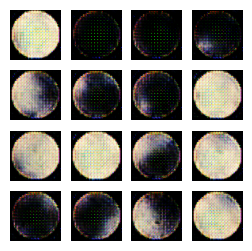

75/75 [==============================] - 15s 202ms/step - d_loss: 87.7193 - g_loss: 41.5105
Epoch 22/500
75/75 [==============================] - 15s 200ms/step - d_loss: 82.3815 - g_loss: 40.3530
Epoch 23/500
75/75 [==============================] - 15s 198ms/step - d_loss: 79.4711 - g_loss: 31.9122
Epoch 24/500
75/75 [==============================] - 15s 203ms/step - d_loss: 72.6756 - g_loss: 35.3545
Epoch 25/500
75/75 [==============================] - 15s 197ms/step - d_loss: 68.0433 - g_loss: 32.7669
Epoch 26/500
75/75 [==============================] - 15s 199ms/step - d_loss: 65.1086 - g_loss: 30.8871
Epoch 27/500
75/75 [==============================] - 15s 201ms/step - d_loss: 57.5744 - g_loss: 27.7023
Epoch 28/500
75/75 [==============================] - 15s 199ms/step - d_loss: 54.1245 - g_loss: 27.7633
Epoch 29/500
75/75 [==============================] - 15s 201ms/step - d_loss: 50.9199 - g_loss: 26.7628
Epoch 30/500
75/75 [==============================] - 15s 202ms/step

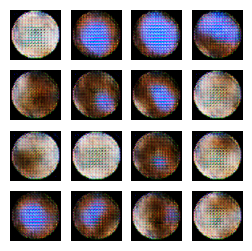

75/75 [==============================] - 15s 201ms/step - d_loss: 46.3682 - g_loss: 23.8489
Epoch 32/500
75/75 [==============================] - 15s 200ms/step - d_loss: 42.2966 - g_loss: 24.4887
Epoch 33/500
75/75 [==============================] - 15s 200ms/step - d_loss: 37.5282 - g_loss: 23.0489
Epoch 34/500
75/75 [==============================] - 15s 205ms/step - d_loss: 36.9898 - g_loss: 24.7620
Epoch 35/500
75/75 [==============================] - 15s 200ms/step - d_loss: 35.0449 - g_loss: 22.8796
Epoch 36/500
75/75 [==============================] - 15s 202ms/step - d_loss: 31.7499 - g_loss: 20.0216
Epoch 37/500
75/75 [==============================] - 15s 201ms/step - d_loss: 29.8688 - g_loss: 18.7239
Epoch 38/500
75/75 [==============================] - 15s 199ms/step - d_loss: 29.0202 - g_loss: 18.5514
Epoch 39/500
75/75 [==============================] - 15s 202ms/step - d_loss: 26.3109 - g_loss: 16.6120
Epoch 40/500
75/75 [==============================] - 15s 199ms/step

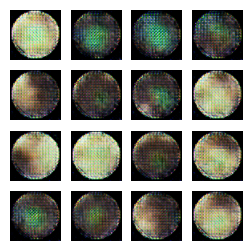

75/75 [==============================] - 16s 211ms/step - d_loss: 23.6300 - g_loss: 14.9099
Epoch 42/500
75/75 [==============================] - 16s 209ms/step - d_loss: 20.9451 - g_loss: 15.3995
Epoch 43/500
75/75 [==============================] - 16s 212ms/step - d_loss: 23.1586 - g_loss: 14.7168
Epoch 44/500
75/75 [==============================] - 15s 207ms/step - d_loss: 20.4541 - g_loss: 13.0239
Epoch 45/500
75/75 [==============================] - 16s 209ms/step - d_loss: 19.1237 - g_loss: 13.0732
Epoch 46/500
75/75 [==============================] - 15s 204ms/step - d_loss: 17.4309 - g_loss: 11.1354
Epoch 47/500
75/75 [==============================] - 15s 201ms/step - d_loss: 16.3749 - g_loss: 10.0988
Epoch 48/500
75/75 [==============================] - 15s 204ms/step - d_loss: 15.0976 - g_loss: 10.5535
Epoch 49/500
75/75 [==============================] - 15s 199ms/step - d_loss: 14.1181 - g_loss: 9.1954
Epoch 50/500
75/75 [==============================] - 15s 199ms/step 

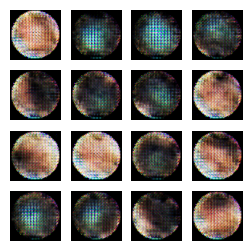

75/75 [==============================] - 15s 205ms/step - d_loss: 13.2500 - g_loss: 9.0433
Epoch 52/500
75/75 [==============================] - 15s 202ms/step - d_loss: 12.7413 - g_loss: 8.3580
Epoch 53/500
75/75 [==============================] - 15s 203ms/step - d_loss: 12.5412 - g_loss: 8.0720
Epoch 54/500
75/75 [==============================] - 15s 202ms/step - d_loss: 11.6601 - g_loss: 7.7266
Epoch 55/500
75/75 [==============================] - 15s 205ms/step - d_loss: 10.5958 - g_loss: 7.3348
Epoch 56/500
75/75 [==============================] - 15s 202ms/step - d_loss: 9.9214 - g_loss: 6.9455
Epoch 57/500
75/75 [==============================] - 15s 202ms/step - d_loss: 9.1248 - g_loss: 6.1772
Epoch 58/500
75/75 [==============================] - 15s 205ms/step - d_loss: 8.7239 - g_loss: 7.0513
Epoch 59/500
75/75 [==============================] - 15s 205ms/step - d_loss: 8.8255 - g_loss: 6.6916
Epoch 60/500
75/75 [==============================] - 15s 206ms/step - d_loss: 8.

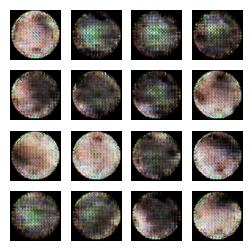

75/75 [==============================] - 16s 209ms/step - d_loss: 7.9152 - g_loss: 5.5844
Epoch 62/500
75/75 [==============================] - 16s 213ms/step - d_loss: 7.1699 - g_loss: 5.0716
Epoch 63/500
75/75 [==============================] - 15s 202ms/step - d_loss: 6.5174 - g_loss: 4.8326
Epoch 64/500
75/75 [==============================] - 15s 200ms/step - d_loss: 6.2815 - g_loss: 4.6818
Epoch 65/500
75/75 [==============================] - 16s 209ms/step - d_loss: 5.9371 - g_loss: 5.0719
Epoch 66/500
75/75 [==============================] - 16s 212ms/step - d_loss: 5.9352 - g_loss: 4.6506
Epoch 67/500
75/75 [==============================] - 15s 206ms/step - d_loss: 5.5418 - g_loss: 3.9594
Epoch 68/500
75/75 [==============================] - 15s 204ms/step - d_loss: 5.4776 - g_loss: 3.8854
Epoch 69/500
75/75 [==============================] - 15s 207ms/step - d_loss: 4.9272 - g_loss: 3.8082
Epoch 70/500
75/75 [==============================] - 15s 204ms/step - d_loss: 5.0846 

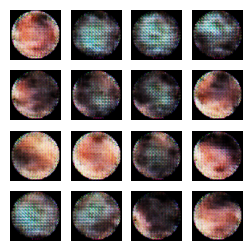

75/75 [==============================] - 15s 205ms/step - d_loss: 4.8974 - g_loss: 3.5008
Epoch 72/500
75/75 [==============================] - 15s 205ms/step - d_loss: 4.2190 - g_loss: 3.1959
Epoch 73/500
75/75 [==============================] - 15s 204ms/step - d_loss: 4.2824 - g_loss: 3.4579
Epoch 74/500
75/75 [==============================] - 15s 205ms/step - d_loss: 3.9811 - g_loss: 2.9480
Epoch 75/500
75/75 [==============================] - 15s 203ms/step - d_loss: 3.8070 - g_loss: 2.7873
Epoch 76/500
75/75 [==============================] - 15s 202ms/step - d_loss: 3.6443 - g_loss: 2.8360
Epoch 77/500
75/75 [==============================] - 15s 204ms/step - d_loss: 3.4106 - g_loss: 2.6923
Epoch 78/500
75/75 [==============================] - 15s 204ms/step - d_loss: 3.3069 - g_loss: 2.6652
Epoch 79/500
75/75 [==============================] - 16s 207ms/step - d_loss: 3.1217 - g_loss: 2.3822
Epoch 80/500
75/75 [==============================] - 16s 219ms/step - d_loss: 3.0287 

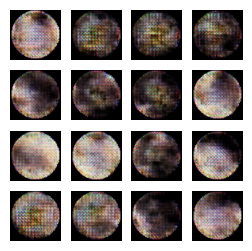

75/75 [==============================] - 17s 221ms/step - d_loss: 2.7891 - g_loss: 2.2093
Epoch 82/500
75/75 [==============================] - 15s 203ms/step - d_loss: 2.8163 - g_loss: 2.4404
Epoch 83/500
75/75 [==============================] - 16s 211ms/step - d_loss: 2.4009 - g_loss: 2.0602
Epoch 84/500
75/75 [==============================] - 15s 207ms/step - d_loss: 2.4474 - g_loss: 1.8387
Epoch 85/500
75/75 [==============================] - 16s 211ms/step - d_loss: 2.1240 - g_loss: 1.8039
Epoch 86/500
75/75 [==============================] - 16s 212ms/step - d_loss: 2.6203 - g_loss: 2.2500
Epoch 87/500
75/75 [==============================] - 17s 221ms/step - d_loss: 2.0515 - g_loss: 1.9522
Epoch 88/500
75/75 [==============================] - 16s 211ms/step - d_loss: 1.9768 - g_loss: 1.8739
Epoch 89/500
75/75 [==============================] - 16s 215ms/step - d_loss: 1.8732 - g_loss: 1.7692
Epoch 90/500
75/75 [==============================] - 16s 210ms/step - d_loss: 1.8181 

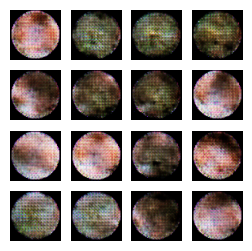

75/75 [==============================] - 16s 209ms/step - d_loss: 1.6792 - g_loss: 1.5180
Epoch 92/500
75/75 [==============================] - 15s 205ms/step - d_loss: 1.6195 - g_loss: 1.4344
Epoch 93/500
75/75 [==============================] - 15s 206ms/step - d_loss: 1.7348 - g_loss: 1.4143
Epoch 94/500
75/75 [==============================] - 15s 205ms/step - d_loss: 1.5875 - g_loss: 1.4216
Epoch 95/500
75/75 [==============================] - 16s 209ms/step - d_loss: 1.5875 - g_loss: 1.2966
Epoch 96/500
75/75 [==============================] - 15s 204ms/step - d_loss: 1.4727 - g_loss: 1.3093
Epoch 97/500
75/75 [==============================] - 15s 204ms/step - d_loss: 1.5784 - g_loss: 1.3415
Epoch 98/500
75/75 [==============================] - 15s 203ms/step - d_loss: 1.3052 - g_loss: 1.1979
Epoch 99/500
75/75 [==============================] - 15s 202ms/step - d_loss: 1.2514 - g_loss: 1.2777
Epoch 100/500
75/75 [==============================] - 15s 203ms/step - d_loss: 1.2628

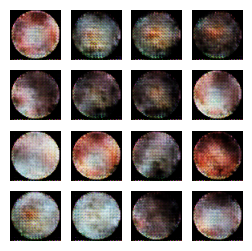

75/75 [==============================] - 15s 207ms/step - d_loss: 1.2862 - g_loss: 1.1571
Epoch 102/500
75/75 [==============================] - 15s 202ms/step - d_loss: 1.2515 - g_loss: 1.0647
Epoch 103/500
75/75 [==============================] - 16s 210ms/step - d_loss: 1.1080 - g_loss: 1.1109
Epoch 104/500
75/75 [==============================] - 16s 212ms/step - d_loss: 1.1697 - g_loss: 1.0643
Epoch 105/500
75/75 [==============================] - 17s 224ms/step - d_loss: 1.1114 - g_loss: 1.0687
Epoch 106/500
75/75 [==============================] - 16s 215ms/step - d_loss: 1.1054 - g_loss: 1.0492
Epoch 107/500
75/75 [==============================] - 16s 209ms/step - d_loss: 1.0863 - g_loss: 1.0152
Epoch 108/500
75/75 [==============================] - 15s 204ms/step - d_loss: 1.0211 - g_loss: 0.9580
Epoch 109/500
75/75 [==============================] - 15s 203ms/step - d_loss: 1.0598 - g_loss: 1.0145
Epoch 110/500
75/75 [==============================] - 15s 204ms/step - d_loss

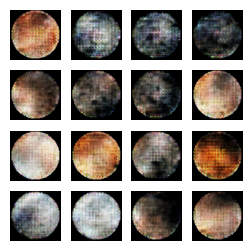

75/75 [==============================] - 16s 209ms/step - d_loss: 0.9566 - g_loss: 0.9036
Epoch 112/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.9965 - g_loss: 0.9859
Epoch 113/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.9887 - g_loss: 0.9381
Epoch 114/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.9685 - g_loss: 0.9674
Epoch 115/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.9452 - g_loss: 0.9138
Epoch 116/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.9377 - g_loss: 0.8955
Epoch 117/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.8842 - g_loss: 0.8937
Epoch 118/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.9037 - g_loss: 0.8569
Epoch 119/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.8740 - g_loss: 0.8889
Epoch 120/500
75/75 [==============================] - 15s 200ms/step - d_loss

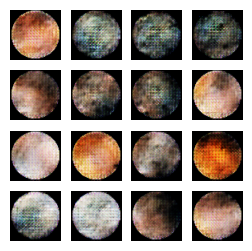

75/75 [==============================] - 16s 209ms/step - d_loss: 0.8957 - g_loss: 0.8737
Epoch 122/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.8795 - g_loss: 0.8727
Epoch 123/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.8770 - g_loss: 0.8914
Epoch 124/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.8127 - g_loss: 0.8150
Epoch 125/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.8266 - g_loss: 0.8473
Epoch 126/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.7985 - g_loss: 0.8511
Epoch 127/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.8002 - g_loss: 0.8655
Epoch 128/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.8001 - g_loss: 0.8187
Epoch 129/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.7750 - g_loss: 0.8953
Epoch 130/500
75/75 [==============================] - 15s 201ms/step - d_loss

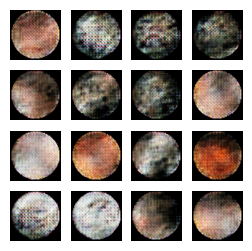

75/75 [==============================] - 15s 203ms/step - d_loss: 0.7553 - g_loss: 0.7970
Epoch 132/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.7576 - g_loss: 0.8110
Epoch 133/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.8205 - g_loss: 0.9287
Epoch 134/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.7509 - g_loss: 0.8333
Epoch 135/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.7660 - g_loss: 0.8223
Epoch 136/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.7299 - g_loss: 0.8804
Epoch 137/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.7561 - g_loss: 0.7808
Epoch 138/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7421 - g_loss: 0.8382
Epoch 139/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7361 - g_loss: 0.8188
Epoch 140/500
75/75 [==============================] - 15s 203ms/step - d_loss

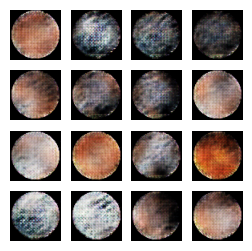

75/75 [==============================] - 16s 212ms/step - d_loss: 0.7394 - g_loss: 0.7918
Epoch 142/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.7442 - g_loss: 0.8196
Epoch 143/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.7395 - g_loss: 0.7630
Epoch 144/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7461 - g_loss: 0.8151
Epoch 145/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.7163 - g_loss: 0.8276
Epoch 146/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.7291 - g_loss: 0.8255
Epoch 147/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7161 - g_loss: 0.7623
Epoch 148/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7283 - g_loss: 0.7676
Epoch 149/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.7058 - g_loss: 0.7822
Epoch 150/500
75/75 [==============================] - 15s 203ms/step - d_loss

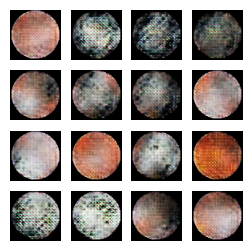

75/75 [==============================] - 16s 207ms/step - d_loss: 0.7185 - g_loss: 0.8131
Epoch 152/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.7230 - g_loss: 0.7952
Epoch 153/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.7037 - g_loss: 0.7824
Epoch 154/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.7179 - g_loss: 0.7946
Epoch 155/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.7127 - g_loss: 0.7875
Epoch 156/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6976 - g_loss: 0.7847
Epoch 157/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6929 - g_loss: 0.8052
Epoch 158/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6849 - g_loss: 0.8095
Epoch 159/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.7251 - g_loss: 0.8514
Epoch 160/500
75/75 [==============================] - 16s 208ms/step - d_loss

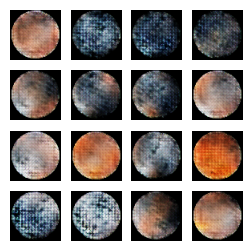

75/75 [==============================] - 16s 207ms/step - d_loss: 0.6792 - g_loss: 0.8169
Epoch 162/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.7056 - g_loss: 0.7819
Epoch 163/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.7380 - g_loss: 0.8593
Epoch 164/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6800 - g_loss: 0.7982
Epoch 165/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6961 - g_loss: 0.7649
Epoch 166/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6884 - g_loss: 0.7753
Epoch 167/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6859 - g_loss: 0.8160
Epoch 168/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.7101 - g_loss: 0.8359
Epoch 169/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.7167 - g_loss: 0.8912
Epoch 170/500
75/75 [==============================] - 16s 208ms/step - d_loss

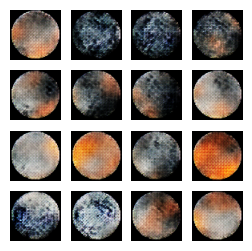

75/75 [==============================] - 16s 207ms/step - d_loss: 0.6883 - g_loss: 0.7608
Epoch 172/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.7098 - g_loss: 0.7836
Epoch 173/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6663 - g_loss: 0.8036
Epoch 174/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6984 - g_loss: 0.7638
Epoch 175/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6897 - g_loss: 0.8139
Epoch 176/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6834 - g_loss: 0.7782
Epoch 177/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6793 - g_loss: 0.7701
Epoch 178/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6978 - g_loss: 0.7966
Epoch 179/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6871 - g_loss: 0.7642
Epoch 180/500
75/75 [==============================] - 15s 203ms/step - d_loss

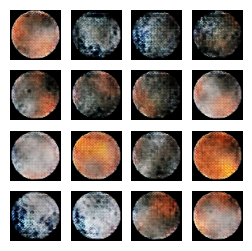

75/75 [==============================] - 16s 208ms/step - d_loss: 0.6858 - g_loss: 0.7948
Epoch 182/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6852 - g_loss: 0.7720
Epoch 183/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6821 - g_loss: 0.7551
Epoch 184/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6988 - g_loss: 0.7596
Epoch 185/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6808 - g_loss: 0.7513
Epoch 186/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.7071 - g_loss: 0.7650
Epoch 187/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6831 - g_loss: 0.7594
Epoch 188/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.7087 - g_loss: 0.8096
Epoch 189/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5946 - g_loss: 0.9778
Epoch 190/500
75/75 [==============================] - 15s 200ms/step - d_loss

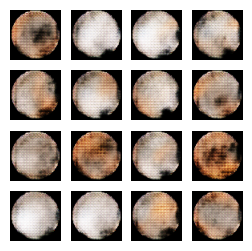

75/75 [==============================] - 15s 204ms/step - d_loss: 0.4905 - g_loss: 1.1302
Epoch 192/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.5311 - g_loss: 0.9969
Epoch 193/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.5448 - g_loss: 1.9732
Epoch 194/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6137 - g_loss: 1.2477
Epoch 195/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.5384 - g_loss: 1.2180
Epoch 196/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6693 - g_loss: 1.0628
Epoch 197/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6844 - g_loss: 1.0099
Epoch 198/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6308 - g_loss: 0.9368
Epoch 199/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6606 - g_loss: 0.9523
Epoch 200/500
75/75 [==============================] - 15s 204ms/step - d_loss

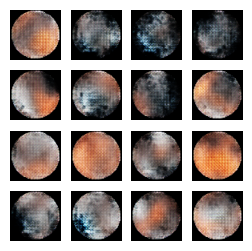

75/75 [==============================] - 15s 202ms/step - d_loss: 0.6679 - g_loss: 0.8590
Epoch 202/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6479 - g_loss: 0.8332
Epoch 203/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6411 - g_loss: 0.8641
Epoch 204/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6557 - g_loss: 0.8375
Epoch 205/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6272 - g_loss: 0.8569
Epoch 206/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6623 - g_loss: 0.8947
Epoch 207/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6711 - g_loss: 0.8916
Epoch 208/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6491 - g_loss: 0.8589
Epoch 209/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6570 - g_loss: 0.8776
Epoch 210/500
75/75 [==============================] - 15s 204ms/step - d_loss

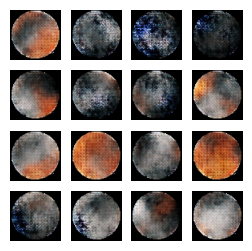

75/75 [==============================] - 15s 205ms/step - d_loss: 0.6729 - g_loss: 0.8233
Epoch 212/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6519 - g_loss: 0.8226
Epoch 213/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6619 - g_loss: 0.8421
Epoch 214/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6562 - g_loss: 0.8519
Epoch 215/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6630 - g_loss: 0.8297
Epoch 216/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6792 - g_loss: 0.8176
Epoch 217/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6623 - g_loss: 0.8128
Epoch 218/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6565 - g_loss: 0.8389
Epoch 219/500
75/75 [==============================] - 16s 216ms/step - d_loss: 0.6493 - g_loss: 0.8387
Epoch 220/500
75/75 [==============================] - 16s 212ms/step - d_loss

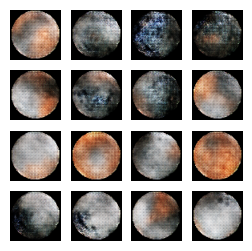

75/75 [==============================] - 16s 209ms/step - d_loss: 0.6840 - g_loss: 0.8760
Epoch 222/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6551 - g_loss: 0.8652
Epoch 223/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6554 - g_loss: 0.8522
Epoch 224/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6505 - g_loss: 0.8807
Epoch 225/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6325 - g_loss: 0.8846
Epoch 226/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6512 - g_loss: 0.9049
Epoch 227/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6490 - g_loss: 0.8839
Epoch 228/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6463 - g_loss: 0.8947
Epoch 229/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6720 - g_loss: 0.8507
Epoch 230/500
75/75 [==============================] - 15s 202ms/step - d_loss

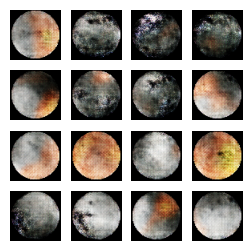

75/75 [==============================] - 16s 218ms/step - d_loss: 0.6413 - g_loss: 0.8793
Epoch 232/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6509 - g_loss: 0.9181
Epoch 233/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6523 - g_loss: 0.8638
Epoch 234/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6357 - g_loss: 0.9121
Epoch 235/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6368 - g_loss: 0.9860
Epoch 236/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6677 - g_loss: 0.9873
Epoch 237/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6610 - g_loss: 0.8850
Epoch 238/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6371 - g_loss: 0.8940
Epoch 239/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6539 - g_loss: 0.8942
Epoch 240/500
75/75 [==============================] - 15s 202ms/step - d_loss

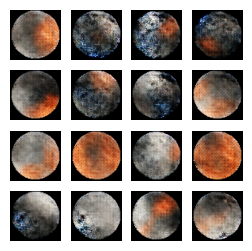

75/75 [==============================] - 15s 204ms/step - d_loss: 0.6298 - g_loss: 0.9235
Epoch 242/500
75/75 [==============================] - 16s 213ms/step - d_loss: 0.6726 - g_loss: 0.9218
Epoch 243/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6409 - g_loss: 0.8860
Epoch 244/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6261 - g_loss: 0.9680
Epoch 245/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6381 - g_loss: 0.9781
Epoch 246/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6280 - g_loss: 0.9417
Epoch 247/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6251 - g_loss: 0.9312
Epoch 248/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6155 - g_loss: 0.9544
Epoch 249/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6017 - g_loss: 0.9545
Epoch 250/500
75/75 [==============================] - 15s 200ms/step - d_loss

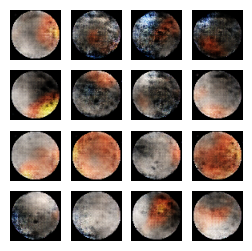

75/75 [==============================] - 15s 201ms/step - d_loss: 0.6309 - g_loss: 0.9290
Epoch 252/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6381 - g_loss: 0.9294
Epoch 253/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6209 - g_loss: 1.0362
Epoch 254/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6522 - g_loss: 0.9135
Epoch 255/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6610 - g_loss: 0.8943
Epoch 256/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6350 - g_loss: 0.8948
Epoch 257/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6502 - g_loss: 0.9300
Epoch 258/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6344 - g_loss: 0.9018
Epoch 259/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6517 - g_loss: 0.9068
Epoch 260/500
75/75 [==============================] - 15s 204ms/step - d_loss

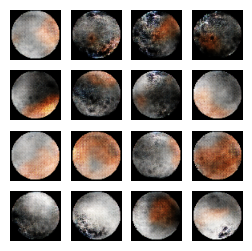

75/75 [==============================] - 15s 204ms/step - d_loss: 0.6455 - g_loss: 0.8806
Epoch 262/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6608 - g_loss: 0.8766
Epoch 263/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6438 - g_loss: 0.9061
Epoch 264/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6563 - g_loss: 0.8790
Epoch 265/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6490 - g_loss: 0.8940
Epoch 266/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6577 - g_loss: 0.8769
Epoch 267/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6756 - g_loss: 0.8638
Epoch 268/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6378 - g_loss: 0.8686
Epoch 269/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6522 - g_loss: 0.8889
Epoch 270/500
75/75 [==============================] - 15s 203ms/step - d_loss

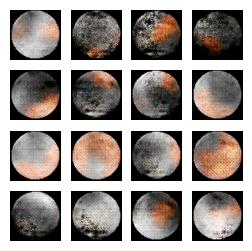

75/75 [==============================] - 15s 204ms/step - d_loss: 0.6446 - g_loss: 0.8842
Epoch 272/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6548 - g_loss: 0.8589
Epoch 273/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6500 - g_loss: 0.8543
Epoch 274/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6727 - g_loss: 0.8511
Epoch 275/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6424 - g_loss: 0.8678
Epoch 276/500
75/75 [==============================] - 15s 199ms/step - d_loss: 0.6623 - g_loss: 0.8903
Epoch 277/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6528 - g_loss: 0.8559
Epoch 278/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6541 - g_loss: 0.8354
Epoch 279/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6523 - g_loss: 0.8582
Epoch 280/500
75/75 [==============================] - 15s 201ms/step - d_loss

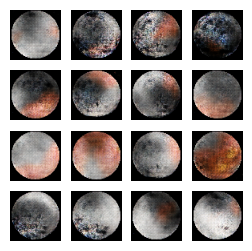

75/75 [==============================] - 15s 206ms/step - d_loss: 0.6611 - g_loss: 0.8407
Epoch 282/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6545 - g_loss: 0.8345
Epoch 283/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6543 - g_loss: 0.8524
Epoch 284/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6595 - g_loss: 0.8216
Epoch 285/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.7278 - g_loss: 0.8809
Epoch 286/500
75/75 [==============================] - 16s 212ms/step - d_loss: 0.6592 - g_loss: 0.8372
Epoch 287/500
75/75 [==============================] - 16s 215ms/step - d_loss: 0.6573 - g_loss: 0.8105
Epoch 288/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6634 - g_loss: 0.8278
Epoch 289/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6648 - g_loss: 0.8399
Epoch 290/500
75/75 [==============================] - 15s 204ms/step - d_loss

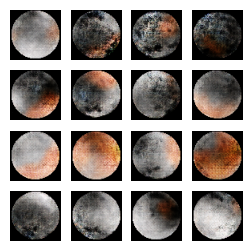

75/75 [==============================] - 16s 210ms/step - d_loss: 0.6588 - g_loss: 0.8068
Epoch 292/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6530 - g_loss: 0.8181
Epoch 293/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6673 - g_loss: 0.8333
Epoch 294/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6498 - g_loss: 0.8292
Epoch 295/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6738 - g_loss: 0.8619
Epoch 296/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6442 - g_loss: 0.8505
Epoch 297/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6647 - g_loss: 0.8409
Epoch 298/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6566 - g_loss: 0.8287
Epoch 299/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6553 - g_loss: 0.8342
Epoch 300/500
75/75 [==============================] - 16s 208ms/step - d_loss

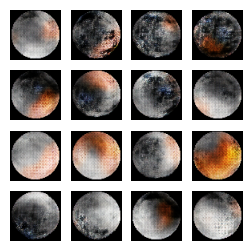

75/75 [==============================] - 16s 212ms/step - d_loss: 0.6614 - g_loss: 0.8315
Epoch 302/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6534 - g_loss: 0.8305
Epoch 303/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6606 - g_loss: 0.8285
Epoch 304/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6472 - g_loss: 0.8167
Epoch 305/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6563 - g_loss: 0.8300
Epoch 306/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6567 - g_loss: 0.8380
Epoch 307/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6472 - g_loss: 0.8379
Epoch 308/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6482 - g_loss: 0.8532
Epoch 309/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6572 - g_loss: 0.8466
Epoch 310/500
75/75 [==============================] - 15s 201ms/step - d_loss

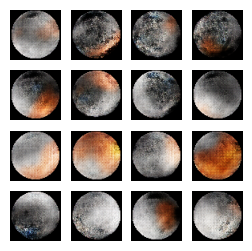

75/75 [==============================] - 15s 203ms/step - d_loss: 0.6523 - g_loss: 0.8504
Epoch 312/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6492 - g_loss: 0.8646
Epoch 313/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6487 - g_loss: 0.8443
Epoch 314/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6670 - g_loss: 0.8700
Epoch 315/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6486 - g_loss: 0.8383
Epoch 316/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6595 - g_loss: 0.8402
Epoch 317/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6493 - g_loss: 0.8425
Epoch 318/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6538 - g_loss: 0.8277
Epoch 319/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6470 - g_loss: 0.8311
Epoch 320/500
75/75 [==============================] - 15s 205ms/step - d_loss

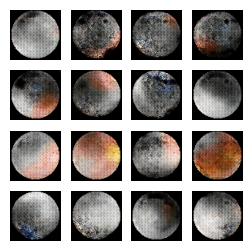

75/75 [==============================] - 15s 204ms/step - d_loss: 0.6473 - g_loss: 0.8626
Epoch 322/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6472 - g_loss: 0.8376
Epoch 323/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6440 - g_loss: 0.8540
Epoch 324/500
75/75 [==============================] - 16s 209ms/step - d_loss: 0.6670 - g_loss: 0.8746
Epoch 325/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.6498 - g_loss: 0.8842
Epoch 326/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6450 - g_loss: 0.8397
Epoch 327/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6495 - g_loss: 0.8597
Epoch 328/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6457 - g_loss: 0.8378
Epoch 329/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6462 - g_loss: 0.8411
Epoch 330/500
75/75 [==============================] - 15s 202ms/step - d_loss

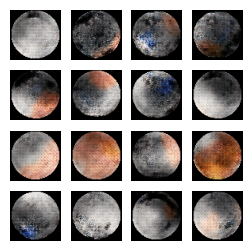

75/75 [==============================] - 15s 204ms/step - d_loss: 0.6467 - g_loss: 0.8350
Epoch 332/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6508 - g_loss: 0.8381
Epoch 333/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6511 - g_loss: 0.8736
Epoch 334/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6471 - g_loss: 0.8510
Epoch 335/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6407 - g_loss: 0.8321
Epoch 336/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6508 - g_loss: 0.8600
Epoch 337/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6389 - g_loss: 0.8403
Epoch 338/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6529 - g_loss: 0.8737
Epoch 339/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6451 - g_loss: 0.8929
Epoch 340/500
75/75 [==============================] - 16s 208ms/step - d_loss

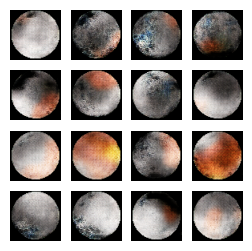

75/75 [==============================] - 16s 215ms/step - d_loss: 0.6438 - g_loss: 0.8825
Epoch 342/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6402 - g_loss: 0.8728
Epoch 343/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6463 - g_loss: 0.8820
Epoch 344/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6297 - g_loss: 0.8715
Epoch 345/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6584 - g_loss: 0.8964
Epoch 346/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6308 - g_loss: 0.8785
Epoch 347/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6448 - g_loss: 0.8675
Epoch 348/500
75/75 [==============================] - 16s 209ms/step - d_loss: 0.6679 - g_loss: 0.8628
Epoch 349/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6277 - g_loss: 0.8604
Epoch 350/500
75/75 [==============================] - 15s 206ms/step - d_loss

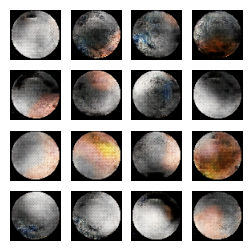

75/75 [==============================] - 16s 208ms/step - d_loss: 0.6312 - g_loss: 0.8871
Epoch 352/500
75/75 [==============================] - 16s 213ms/step - d_loss: 0.6201 - g_loss: 0.8547
Epoch 353/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6553 - g_loss: 0.8676
Epoch 354/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6113 - g_loss: 0.8869
Epoch 355/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6325 - g_loss: 0.8942
Epoch 356/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6206 - g_loss: 0.8937
Epoch 357/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.6520 - g_loss: 0.9180
Epoch 358/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.6303 - g_loss: 0.9397
Epoch 359/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.6057 - g_loss: 0.9269
Epoch 360/500
75/75 [==============================] - 16s 209ms/step - d_loss

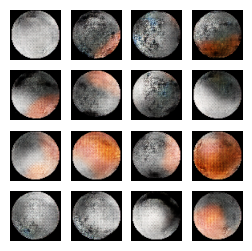

75/75 [==============================] - 16s 210ms/step - d_loss: 0.6170 - g_loss: 0.8853
Epoch 362/500
75/75 [==============================] - 16s 214ms/step - d_loss: 0.6392 - g_loss: 0.9117
Epoch 363/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6296 - g_loss: 0.8964
Epoch 364/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6359 - g_loss: 0.8774
Epoch 365/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5987 - g_loss: 0.8874
Epoch 366/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6234 - g_loss: 0.8934
Epoch 367/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6631 - g_loss: 0.9412
Epoch 368/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6236 - g_loss: 0.9132
Epoch 369/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6227 - g_loss: 0.9137
Epoch 370/500
75/75 [==============================] - 15s 202ms/step - d_loss

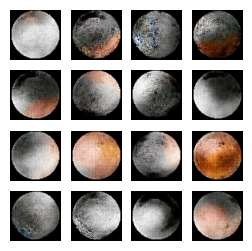

75/75 [==============================] - 16s 214ms/step - d_loss: 0.6041 - g_loss: 0.9067
Epoch 372/500
75/75 [==============================] - 16s 213ms/step - d_loss: 0.6103 - g_loss: 1.0072
Epoch 373/500
75/75 [==============================] - 16s 217ms/step - d_loss: 0.6037 - g_loss: 0.9479
Epoch 374/500
75/75 [==============================] - 16s 219ms/step - d_loss: 0.6327 - g_loss: 0.9508
Epoch 375/500
75/75 [==============================] - 16s 209ms/step - d_loss: 0.6067 - g_loss: 0.9319
Epoch 376/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6077 - g_loss: 0.9204
Epoch 377/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6156 - g_loss: 0.9305
Epoch 378/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.6123 - g_loss: 0.9325
Epoch 379/500
75/75 [==============================] - 16s 209ms/step - d_loss: 0.6029 - g_loss: 0.9596
Epoch 380/500
75/75 [==============================] - 15s 204ms/step - d_loss

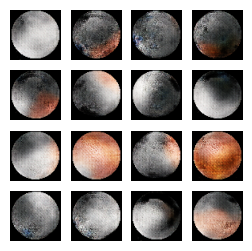

75/75 [==============================] - 16s 208ms/step - d_loss: 0.6287 - g_loss: 0.9544
Epoch 382/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5780 - g_loss: 0.9526
Epoch 383/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6345 - g_loss: 0.9811
Epoch 384/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6054 - g_loss: 0.9305
Epoch 385/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6152 - g_loss: 0.9781
Epoch 386/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6321 - g_loss: 0.9288
Epoch 387/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6982 - g_loss: 0.9964
Epoch 388/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6191 - g_loss: 0.9209
Epoch 389/500
75/75 [==============================] - 15s 207ms/step - d_loss: 0.5706 - g_loss: 0.9709
Epoch 390/500
75/75 [==============================] - 16s 209ms/step - d_loss

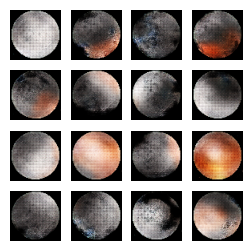

75/75 [==============================] - 16s 210ms/step - d_loss: 0.6742 - g_loss: 1.1207
Epoch 392/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.5918 - g_loss: 0.9893
Epoch 393/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.6151 - g_loss: 0.9523
Epoch 394/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5781 - g_loss: 0.9361
Epoch 395/500
75/75 [==============================] - 16s 210ms/step - d_loss: 0.6433 - g_loss: 0.9372
Epoch 396/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5973 - g_loss: 0.9650
Epoch 397/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5720 - g_loss: 0.9815
Epoch 398/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.5584 - g_loss: 0.9952
Epoch 399/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5930 - g_loss: 1.0257
Epoch 400/500
75/75 [==============================] - 15s 204ms/step - d_loss

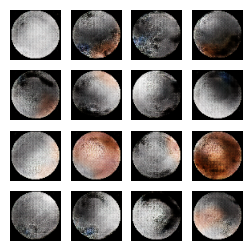

75/75 [==============================] - 16s 210ms/step - d_loss: 0.5681 - g_loss: 1.0273
Epoch 402/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5065 - g_loss: 1.0077
Epoch 403/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.6117 - g_loss: 1.0646
Epoch 404/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5756 - g_loss: 1.0504
Epoch 405/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6035 - g_loss: 0.9828
Epoch 406/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5525 - g_loss: 0.9734
Epoch 407/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5437 - g_loss: 1.1524
Epoch 408/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.6322 - g_loss: 1.1486
Epoch 409/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5679 - g_loss: 1.0433
Epoch 410/500
75/75 [==============================] - 15s 202ms/step - d_loss

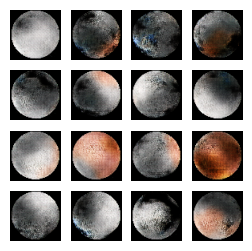

75/75 [==============================] - 16s 210ms/step - d_loss: 0.5514 - g_loss: 1.0172
Epoch 412/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5280 - g_loss: 1.1158
Epoch 413/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5750 - g_loss: 1.0665
Epoch 414/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.5233 - g_loss: 1.0958
Epoch 415/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.4886 - g_loss: 1.0994
Epoch 416/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.5983 - g_loss: 1.0382
Epoch 417/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.4927 - g_loss: 1.0616
Epoch 418/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.5579 - g_loss: 1.0942
Epoch 419/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.4944 - g_loss: 1.0324
Epoch 420/500
75/75 [==============================] - 15s 207ms/step - d_loss

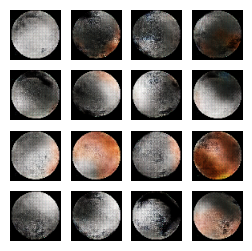

75/75 [==============================] - 15s 204ms/step - d_loss: 0.5598 - g_loss: 1.2243
Epoch 422/500
75/75 [==============================] - 16s 208ms/step - d_loss: 0.5734 - g_loss: 1.0701
Epoch 423/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.6054 - g_loss: 1.0948
Epoch 424/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5044 - g_loss: 1.0377
Epoch 425/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.5246 - g_loss: 1.0691
Epoch 426/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5926 - g_loss: 1.2863
Epoch 427/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5276 - g_loss: 1.1143
Epoch 428/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.3743 - g_loss: 1.1091
Epoch 429/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.8855 - g_loss: 1.3995
Epoch 430/500
75/75 [==============================] - 16s 210ms/step - d_loss

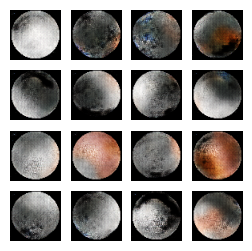

75/75 [==============================] - 15s 205ms/step - d_loss: 0.4733 - g_loss: 1.0339
Epoch 432/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5306 - g_loss: 1.1415
Epoch 433/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.5271 - g_loss: 1.1509
Epoch 434/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.5189 - g_loss: 1.0289
Epoch 435/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6085 - g_loss: 1.1100
Epoch 436/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.4812 - g_loss: 1.1236
Epoch 437/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.6088 - g_loss: 1.0745
Epoch 438/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.5962 - g_loss: 1.0598
Epoch 439/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.4634 - g_loss: 1.0855
Epoch 440/500
75/75 [==============================] - 15s 205ms/step - d_loss

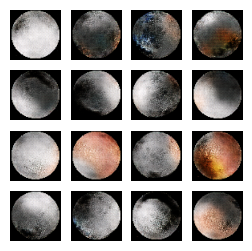

75/75 [==============================] - 15s 206ms/step - d_loss: 0.5759 - g_loss: 1.0944
Epoch 442/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5900 - g_loss: 1.0923
Epoch 443/500
75/75 [==============================] - 16s 209ms/step - d_loss: 0.5365 - g_loss: 1.1048
Epoch 444/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.5739 - g_loss: 1.3806
Epoch 445/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.4894 - g_loss: 1.5710
Epoch 446/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5470 - g_loss: 1.1364
Epoch 447/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.5185 - g_loss: 1.1324
Epoch 448/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.4243 - g_loss: 1.0950
Epoch 449/500
75/75 [==============================] - 15s 202ms/step - d_loss: 0.5344 - g_loss: 1.1027
Epoch 450/500
75/75 [==============================] - 15s 202ms/step - d_loss

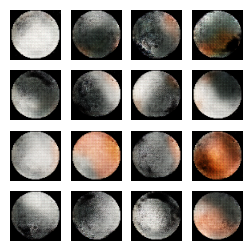

75/75 [==============================] - 16s 208ms/step - d_loss: 0.1671 - g_loss: 1.1897
Epoch 452/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.4905 - g_loss: 1.1875
Epoch 453/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.8414 - g_loss: 1.5280
Epoch 454/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.5291 - g_loss: 1.2912
Epoch 455/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.2761 - g_loss: 1.1052
Epoch 456/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.5606 - g_loss: 1.0878
Epoch 457/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.4562 - g_loss: 1.2216
Epoch 458/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.4380 - g_loss: 1.1170
Epoch 459/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.3128 - g_loss: 1.1803
Epoch 460/500
75/75 [==============================] - 15s 201ms/step - d_loss

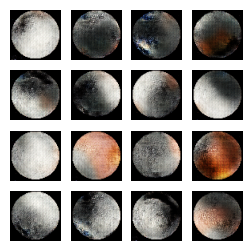

75/75 [==============================] - 15s 204ms/step - d_loss: 0.4767 - g_loss: 1.2541
Epoch 462/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.4658 - g_loss: 1.1936
Epoch 463/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.1077 - g_loss: 1.2006
Epoch 464/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.7062 - g_loss: 1.4829
Epoch 465/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.5333 - g_loss: 1.2603
Epoch 466/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.4312 - g_loss: 1.1961
Epoch 467/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.3831 - g_loss: 1.2489
Epoch 468/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.4487 - g_loss: 1.1901
Epoch 469/500
75/75 [==============================] - 15s 203ms/step - d_loss: 0.5786 - g_loss: 1.1500
Epoch 470/500
75/75 [==============================] - 15s 200ms/step - d_loss

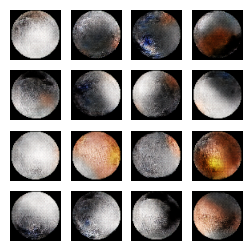

75/75 [==============================] - 15s 203ms/step - d_loss: 0.5099 - g_loss: 1.2168
Epoch 472/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.5875 - g_loss: 1.2734
Epoch 473/500
75/75 [==============================] - 15s 200ms/step - d_loss: 0.3483 - g_loss: 1.2396
Epoch 474/500
75/75 [==============================] - 15s 201ms/step - d_loss: 0.1659 - g_loss: 1.2475
Epoch 475/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.3719 - g_loss: 1.2746
Epoch 476/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.2739 - g_loss: 1.3422
Epoch 477/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.3984 - g_loss: 1.3390
Epoch 478/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.4434 - g_loss: 1.5580
Epoch 479/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.4953 - g_loss: 1.3997
Epoch 480/500
75/75 [==============================] - 15s 205ms/step - d_loss

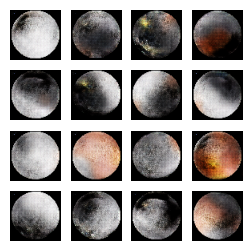

75/75 [==============================] - 16s 209ms/step - d_loss: 0.3254 - g_loss: 1.4680
Epoch 482/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.0864 - g_loss: 1.3145
Epoch 483/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6638 - g_loss: 2.2995
Epoch 484/500
75/75 [==============================] - 15s 205ms/step - d_loss: -0.0066 - g_loss: 2.0882
Epoch 485/500
75/75 [==============================] - 16s 211ms/step - d_loss: 0.1807 - g_loss: 1.4703
Epoch 486/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.0013 - g_loss: 1.3829
Epoch 487/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.2916 - g_loss: 1.6344
Epoch 488/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.0018 - g_loss: 1.4284
Epoch 489/500
75/75 [==============================] - 15s 204ms/step - d_loss: 0.7824 - g_loss: 1.3899
Epoch 490/500
75/75 [==============================] - 15s 204ms/step - d_los

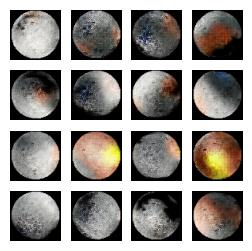

75/75 [==============================] - 16s 208ms/step - d_loss: 0.2619 - g_loss: 1.4406
Epoch 492/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.6410 - g_loss: 2.0990
Epoch 493/500
75/75 [==============================] - 15s 205ms/step - d_loss: 0.3928 - g_loss: 1.8520
Epoch 494/500
75/75 [==============================] - 15s 205ms/step - d_loss: 1.1759 - g_loss: 2.6107
Epoch 495/500
75/75 [==============================] - 16s 211ms/step - d_loss: -0.1451 - g_loss: 1.5805
Epoch 496/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.0214 - g_loss: 1.4585
Epoch 497/500
75/75 [==============================] - 16s 207ms/step - d_loss: 0.4473 - g_loss: 1.4674
Epoch 498/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.8766 - g_loss: 1.6465
Epoch 499/500
75/75 [==============================] - 15s 206ms/step - d_loss: 0.0470 - g_loss: 1.4006
Epoch 500/500
75/75 [==============================] - 15s 206ms/step - d_los

In [18]:
# number of epochs
NUM_EPOCHS = 500 

dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

# Deployment

Tworzenie gifa z wyników generowania planet w każdej epoce

In [19]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "./results_064_v1/*.jpg"
fp_out = "./results_064_v1/epochs64_v1.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1, loop=0)